In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# add the parent dir of notebooks to path
sys.path.append(os.path.dirname(os.path.abspath('')))

OUTPUT_DIRECTORY = os.path.join(os.path.abspath(''), "01_Dataset_Visualisation_output")
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

# Dataset Visualisation

In this notebook, we aim to visualise the open anomaly detection dataset(s) and make sense of them, to see if they are capable of representing the Skyscanner redirects data.

---
## Numenta Anomaly Benchmark - Tweets

This dataset seems to contain the volume of tweets in a given time interval pertaining to various stock market stocks.

In [2]:
from data.nab.real_tweets import nab_multivariate_tweet_volume, STOCK_NAMES
tweet_df = nab_multivariate_tweet_volume(labels="points")

In [3]:
tweet_df.describe()

value_AAPL    value_AMZN     value_CRM     value_CVS      value_FB  \
count  15902.000000  15902.000000  15902.000000  15902.000000  15902.000000   
mean      85.552320     53.060496      3.349327      0.358508     17.733996   
std      321.050721     30.691272      4.605324      1.092109     19.731942   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       29.000000     36.000000      1.000000      0.000000      9.000000   
50%       47.000000     50.000000      2.000000      0.000000     14.000000   
75%       76.000000     65.000000      5.000000      0.000000     22.000000   
max    13479.000000   1673.000000    209.000000     50.000000   1258.000000   

         value_GOOG     value_IBM      value_KO     value_PFE     value_UPS  
count  15902.000000  15902.000000  15902.000000  15902.000000  15902.000000  
mean      20.658156      4.387750     11.360709      0.864168      5.443969  
std       18.573134      5.500823     24.772953      1.460690     21.551400  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%       11.000000      1.000000      5.000000      0.000000      0.000000  
50%       16.000000      3.000000      8.000000      0.000000      2.000000  
75%       26.000000      6.000000     13.000000      1.000000      4.000000  
max      465.000000    139.000000   2241.000000     36.000000    231.000000

In [4]:
def plot_time_series_nab_tweets(dat, anomaly_alpha=0.2, extra_label=""):
    plt.ion()
    fig, axes = plt.subplots(len(STOCK_NAMES), 1, figsize=(15, 3*len(STOCK_NAMES)), dpi=160)

    def color_map(value):
        if value is True:
            return (1,0,0)
        else:
            return (0,0,1)

    for i, stock in enumerate(STOCK_NAMES):
        ax = axes[i]
        ax.title.set_text(stock)
        ax.scatter(dat.index, dat[f"value_{stock}"], c=dat[f"anomaly_{stock}"].apply(color_map), s=1, marker=",")
        ax.fill_between(dat.index, 0, 1, where=dat[f"anomaly_{stock}"], color="red", alpha=anomaly_alpha, transform=ax.get_xaxis_transform())
        ax.set_xticks([])
        ax.set_ylabel("No. of tweets")
        ax.set_xlabel("Timestep")
    
    fig.tight_layout()
    plt.draw()
    plt.savefig(f"{OUTPUT_DIRECTORY}/nab_tweets{extra_label}.png")


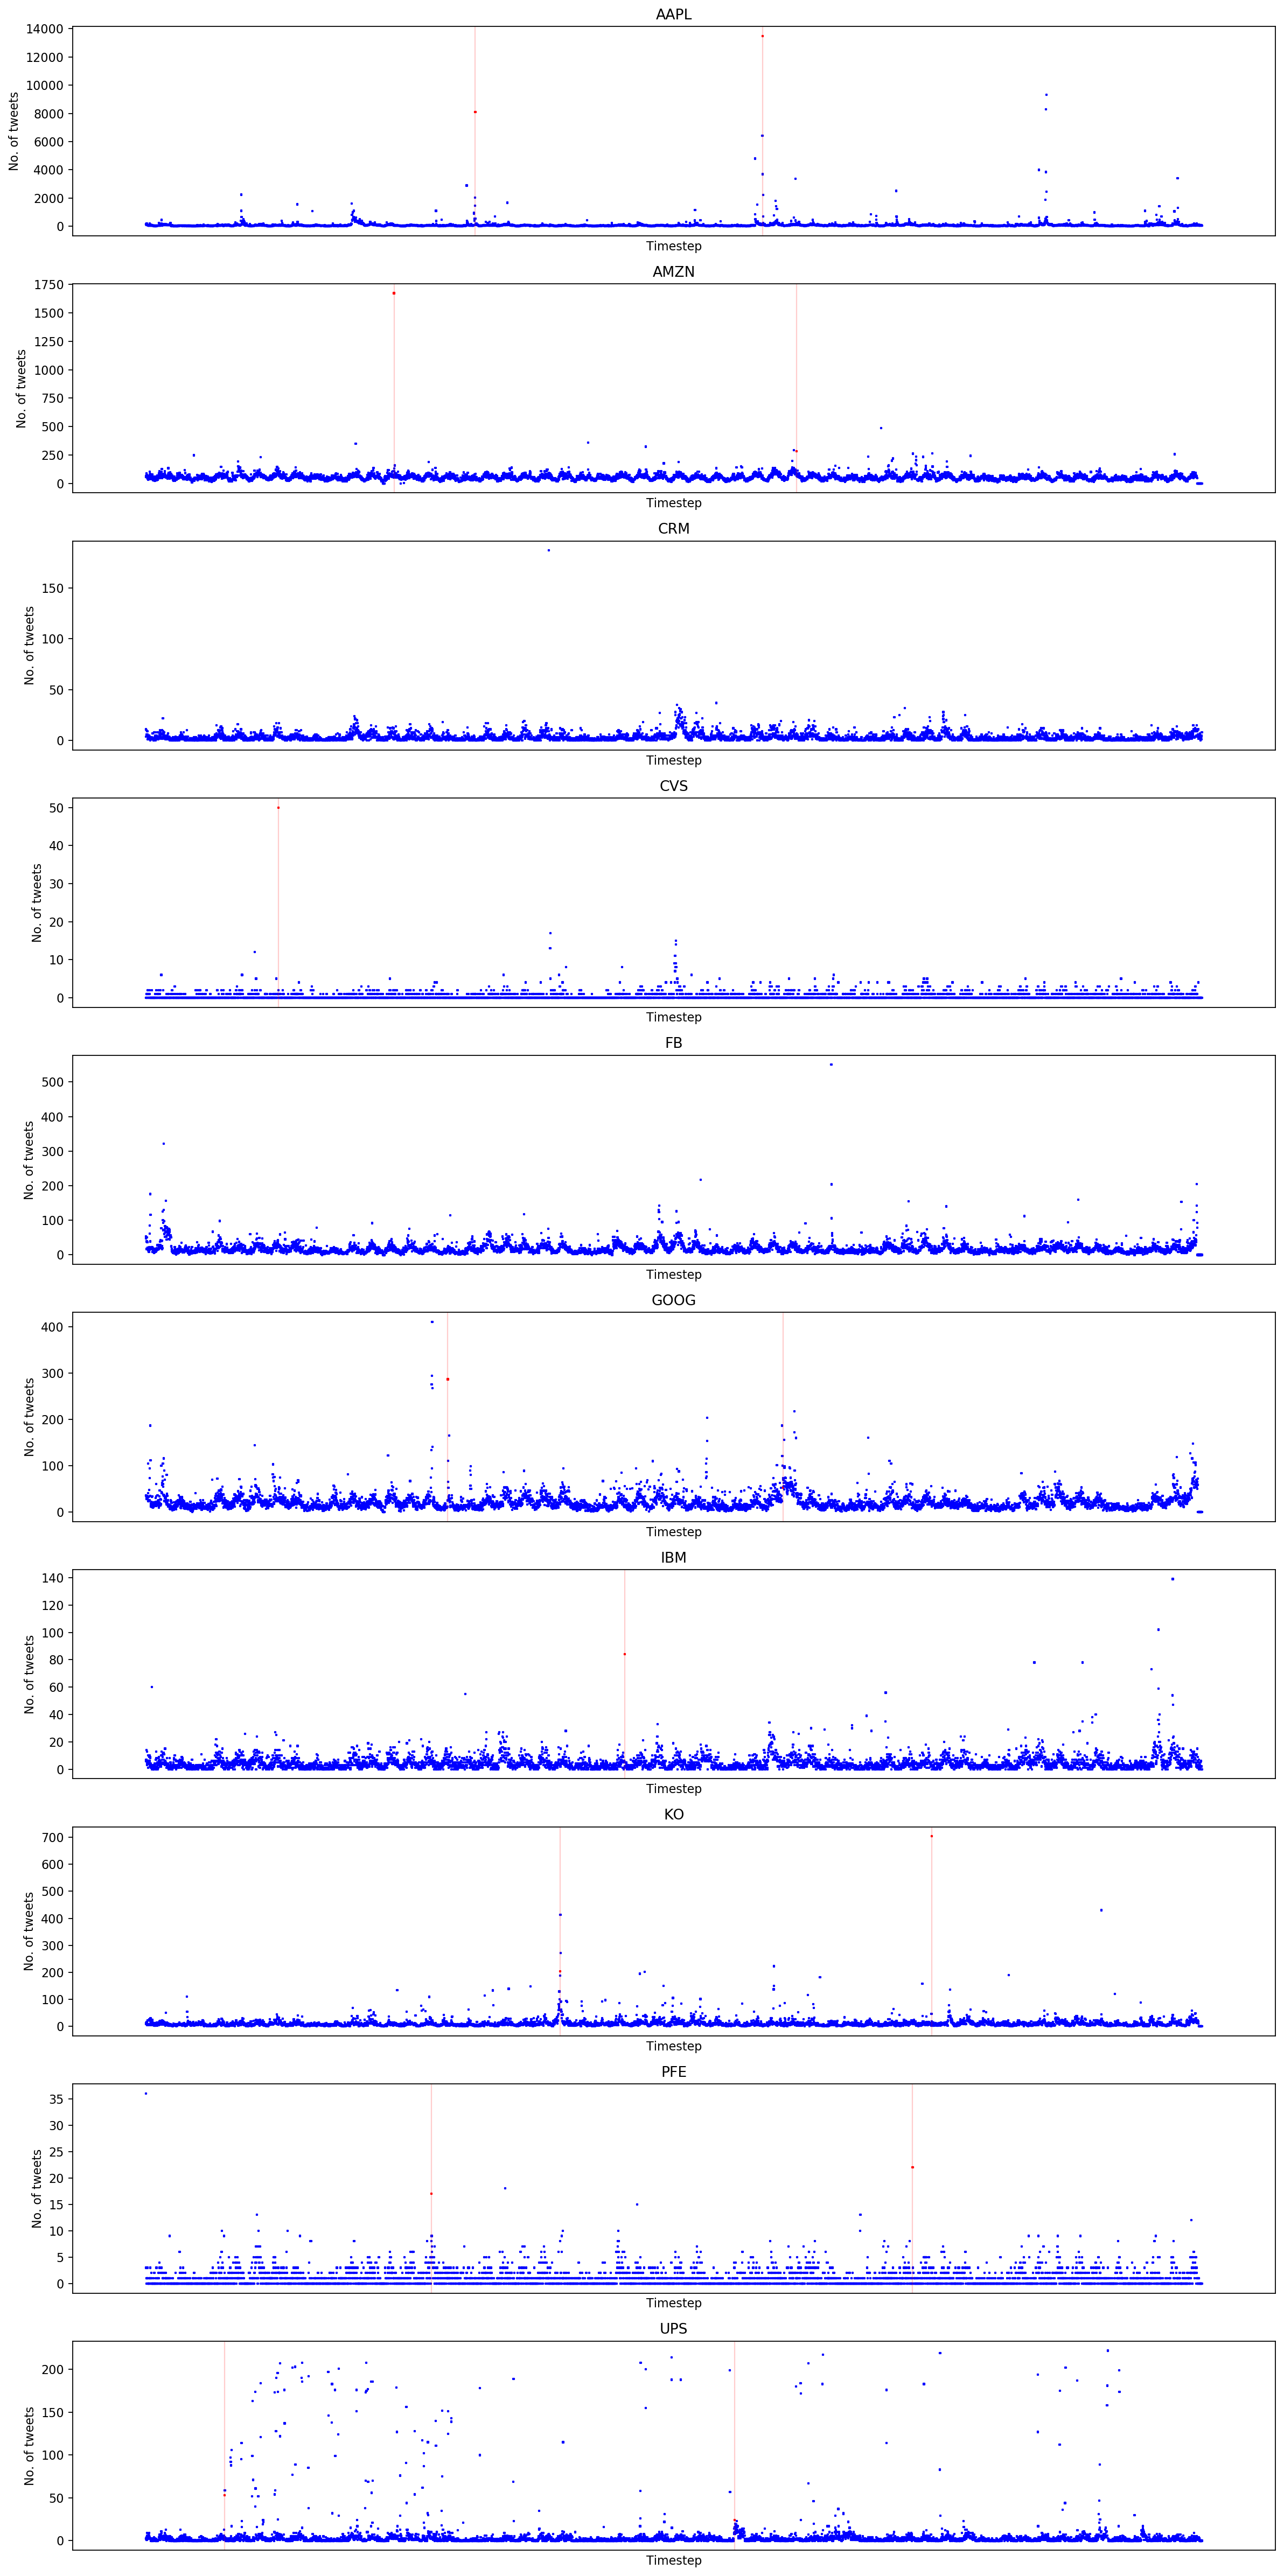

In [5]:
# plot_time_series_nab(df.iloc[:2500])
plot_time_series_nab_tweets(tweet_df.iloc[::3])

### Analysis/Interpretation

Positivies:
* _Seasonal/Periodic_ - The patterns in tweet data appear to have seasonal and trend components, and do appear to fit with the redirects data.
* _Multivariate_ - the data is inherently multivariate - the series overlap in time and it is clear that tweets happening at the same time will have some cross-correlation.

Negatives:
* _Large Windows_ - The tweets data anomaly windows span a large amount around the actual anomalous points - may reduce overall accuracy
* _Data Quantity_ - 15000 datapoints in each series, is not small, but is not exactly in the territory of "deep learning"

---
## Numenta Anomaly Benchmark - Artificial Data

The artificial data is purely synthetic. There are variations with noise and anomalies, that we will use.

In [6]:
from data.nab.artificial import nab_artificial, ARTIFICIAL_SERIES
art_df = nab_artificial()

In [7]:
art_df.describe()

value_art_daily_flatmiddle  value_art_daily_jumpsup  \
count                 4032.000000              4032.000000   
mean                    18.981142                44.494254   
std                     45.374171                32.432473   
min                    -21.998789                18.001010   
25%                    -19.929162                19.991382   
50%                    -17.541296                21.648503   
75%                     74.425223                76.435943   
max                     87.958348               164.947481   

       value_art_daily_jumpsdown  
count                4032.000000  
mean                   41.509772  
std                    27.512033  
min                    18.002040  
25%                    19.986745  
50%                    21.637211  
75%                    74.864803  
max                    87.998382

In [8]:
import string

def plot_time_series_nab_artificial(dat):
    plt.ion()
    fig, axes = plt.subplots(len(ARTIFICIAL_SERIES), 1, figsize=(15, 3*len(ARTIFICIAL_SERIES)), dpi=600)

    for i, series in enumerate(ARTIFICIAL_SERIES):
        ax = axes[i]
        ax.title.set_text(string.capwords(
            series.replace("value_", "").replace("_", " ").replace("art", "artificial - ")
        ))
        ax.plot(dat.index, dat[f"value_{series}"], marker=",")
        ax.fill_between(dat.index, 0, 1, where=dat[f"anomaly_{series}"], color="red", alpha=0.2, transform=ax.get_xaxis_transform())
        ax.set_xticks([])
    
    fig.tight_layout()
    plt.draw()
    plt.savefig(f"{OUTPUT_DIRECTORY}/nab_artificial.png")


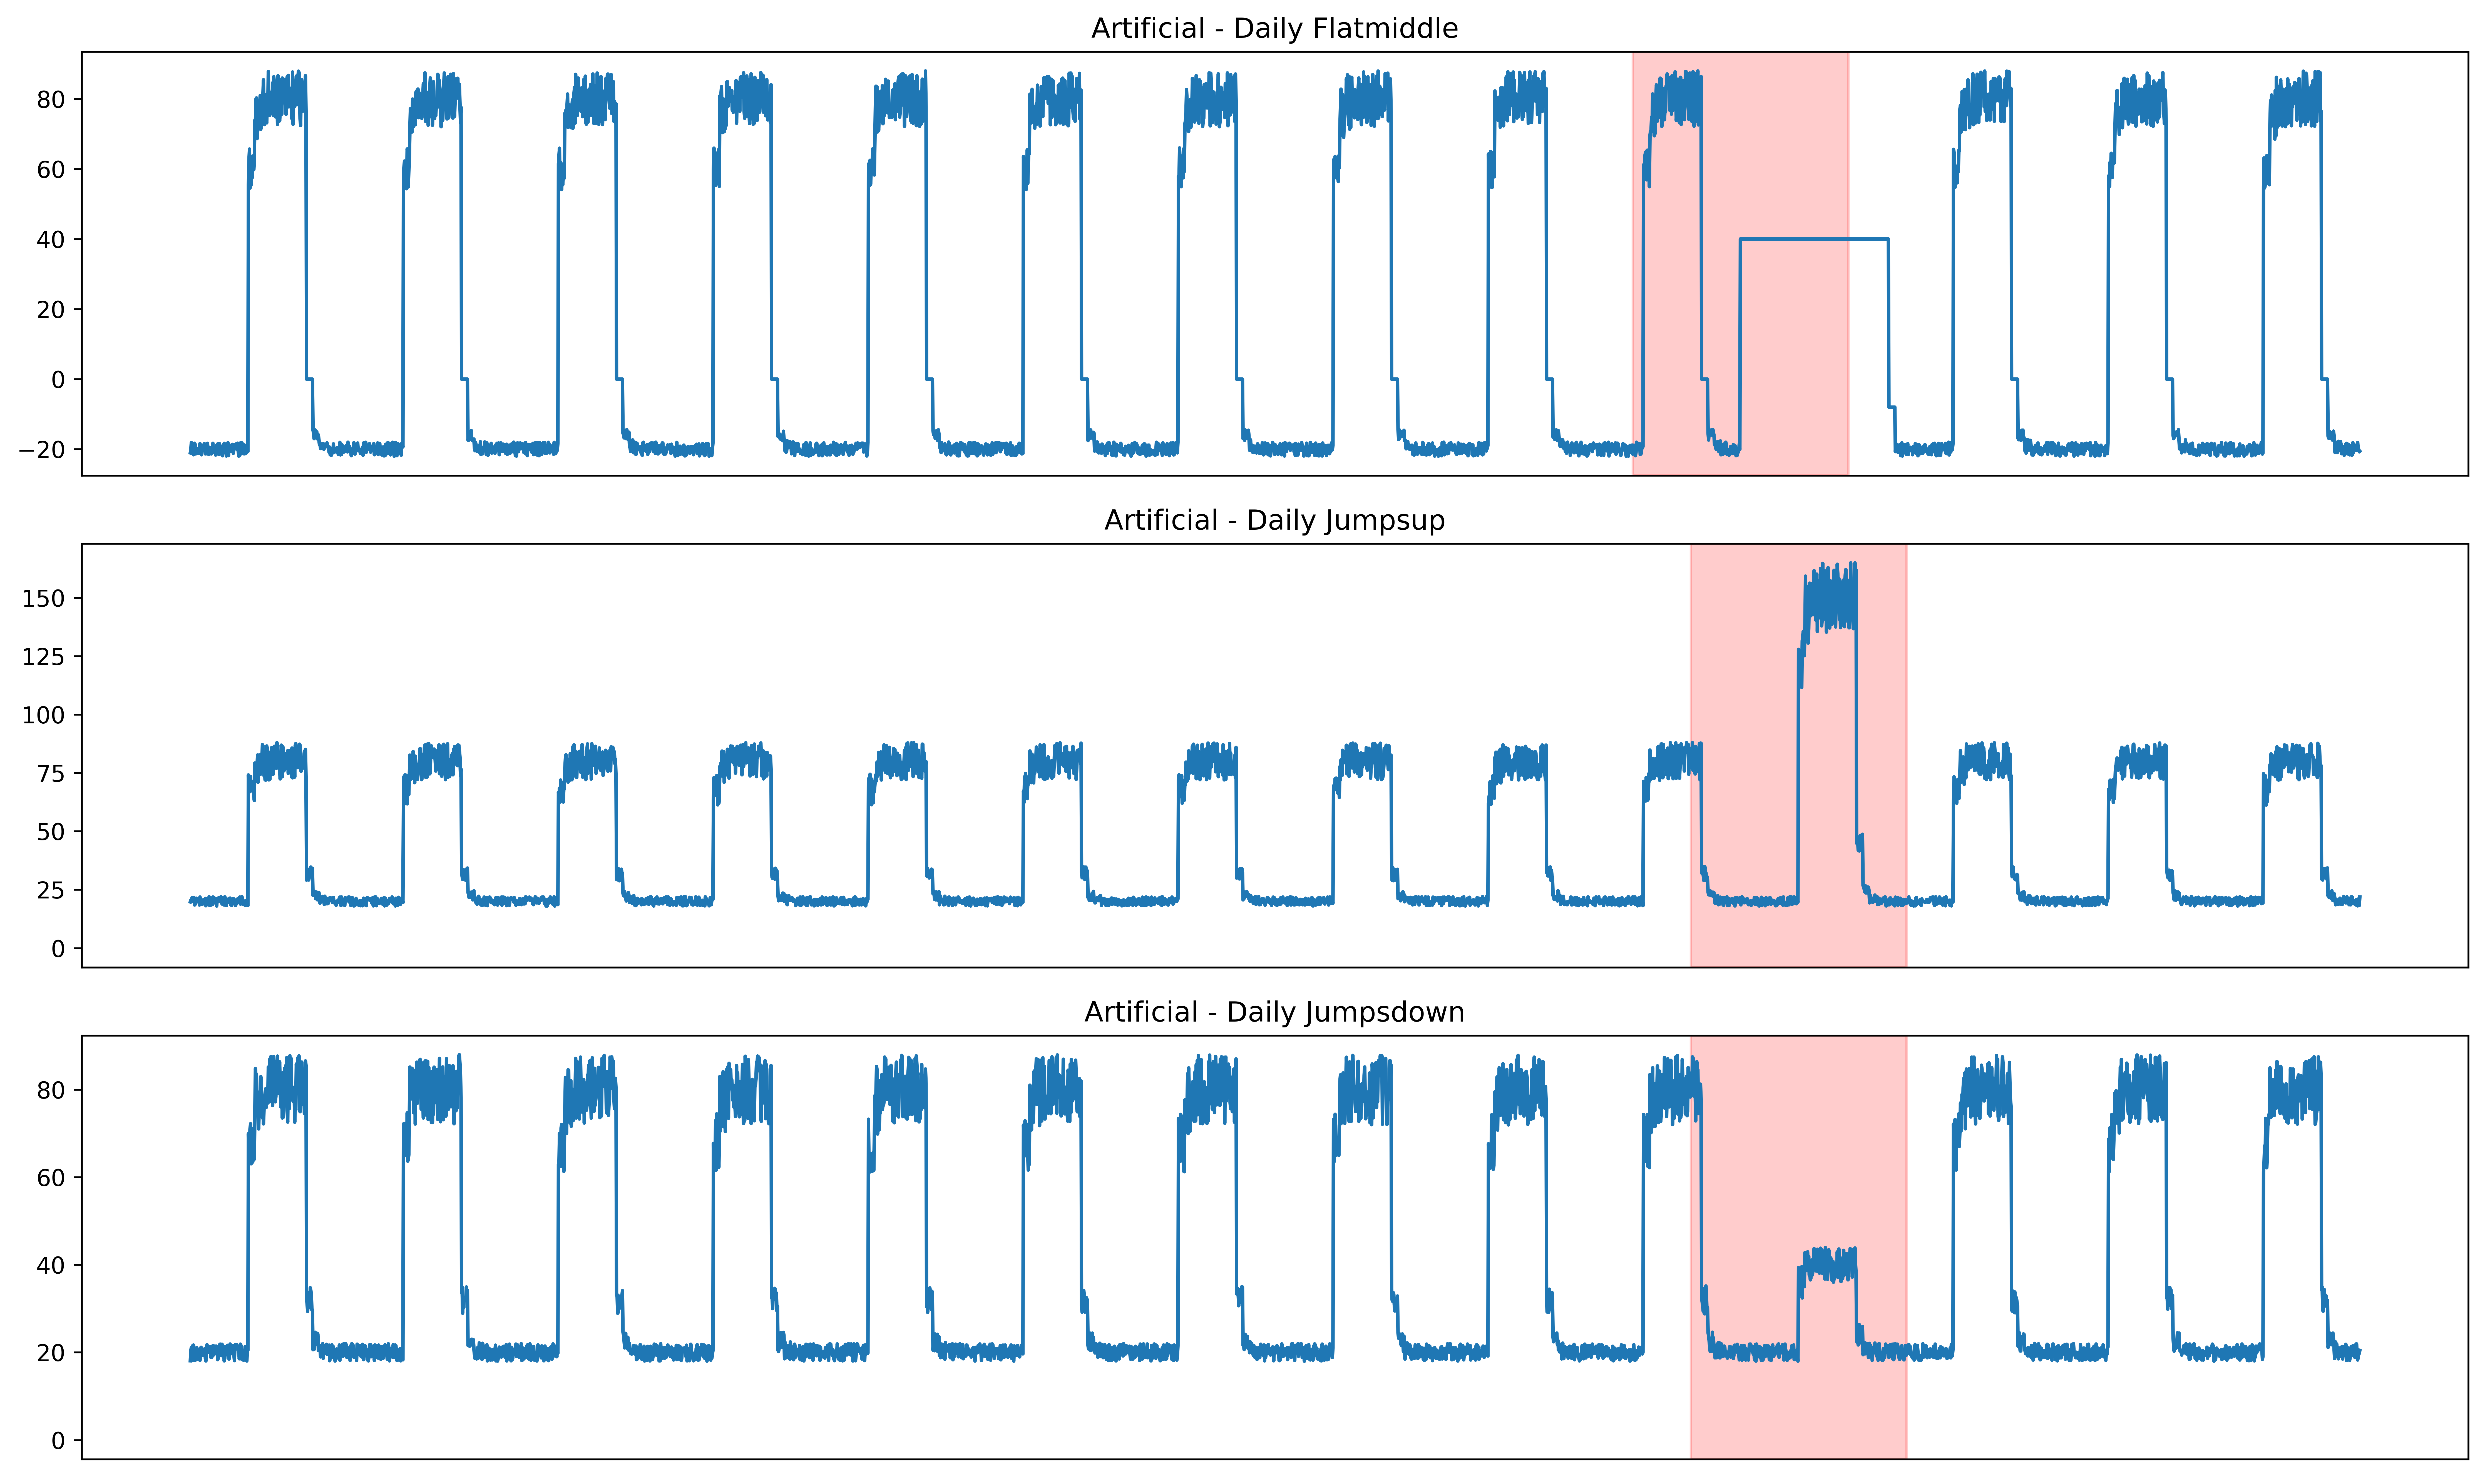

In [9]:
plot_time_series_nab_artificial(art_df)

### Analysis/Interpretation:

Positives:
* _Clearly defined anomalies_ - the anomalies are clearly visible to the human eye as such, intuitive to reason about
* _Cyclic, seasonal data_ - resembles skyscanner traffic curves, if a little extreme

Negatives:
* Anomaly windows seem to be too wide - nominal values are covered within them
* 4000 datapoints is not a lot to train on for deep learning techniques
* __Univariate__ - we canot leverage cross-correlations between time series to detect anomalies, and is not representative of the skyscanner redirects summaries that the model will be run on

---
## Numenta Anomaly Benchmark - NYC Taxi

> Number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm. The raw data is from the NYC Taxi and Limousine Commission. The data file included here consists of aggregating the total number of taxi passengers into 30 minute buckets.

In [10]:
from data.nab.nyc_taxi import nab_nyc_taxi
nyc_df = nab_nyc_taxi()

In [11]:
nyc_df.describe()

value
count  10320.000000
mean   15137.569380
std     6939.495808
min        8.000000
25%    10262.000000
50%    16778.000000
75%    19838.750000
max    39197.000000

In [12]:
def plot_time_series_nab_nyc_taxi(dat):
    plt.ion()
    fig, axes = plt.subplots(1, 1, figsize=(15, 3), dpi=300)

    def color_map(value):
        if value is True:
            return (1,0,0)
        else:
            return (0,0,1)

    ax = axes
    ax.title.set_text("NYC Taxi Passenger Count")
    ax.scatter(dat.index, dat[f"value"], marker=",", c=dat[f"anomaly"].apply(color_map), s=1)
    ax.fill_between(dat.index, 0, 1, where=dat[f"anomaly"], color="red", alpha=0.1, transform=ax.get_xaxis_transform())
    ax.set_xticks([])
    ax.set_xlabel("Timestep")
    ax.set_ylabel("No. of passengers")

    fig.tight_layout()
    plt.draw()
    plt.savefig(f"{OUTPUT_DIRECTORY}/nab_nyc.png")


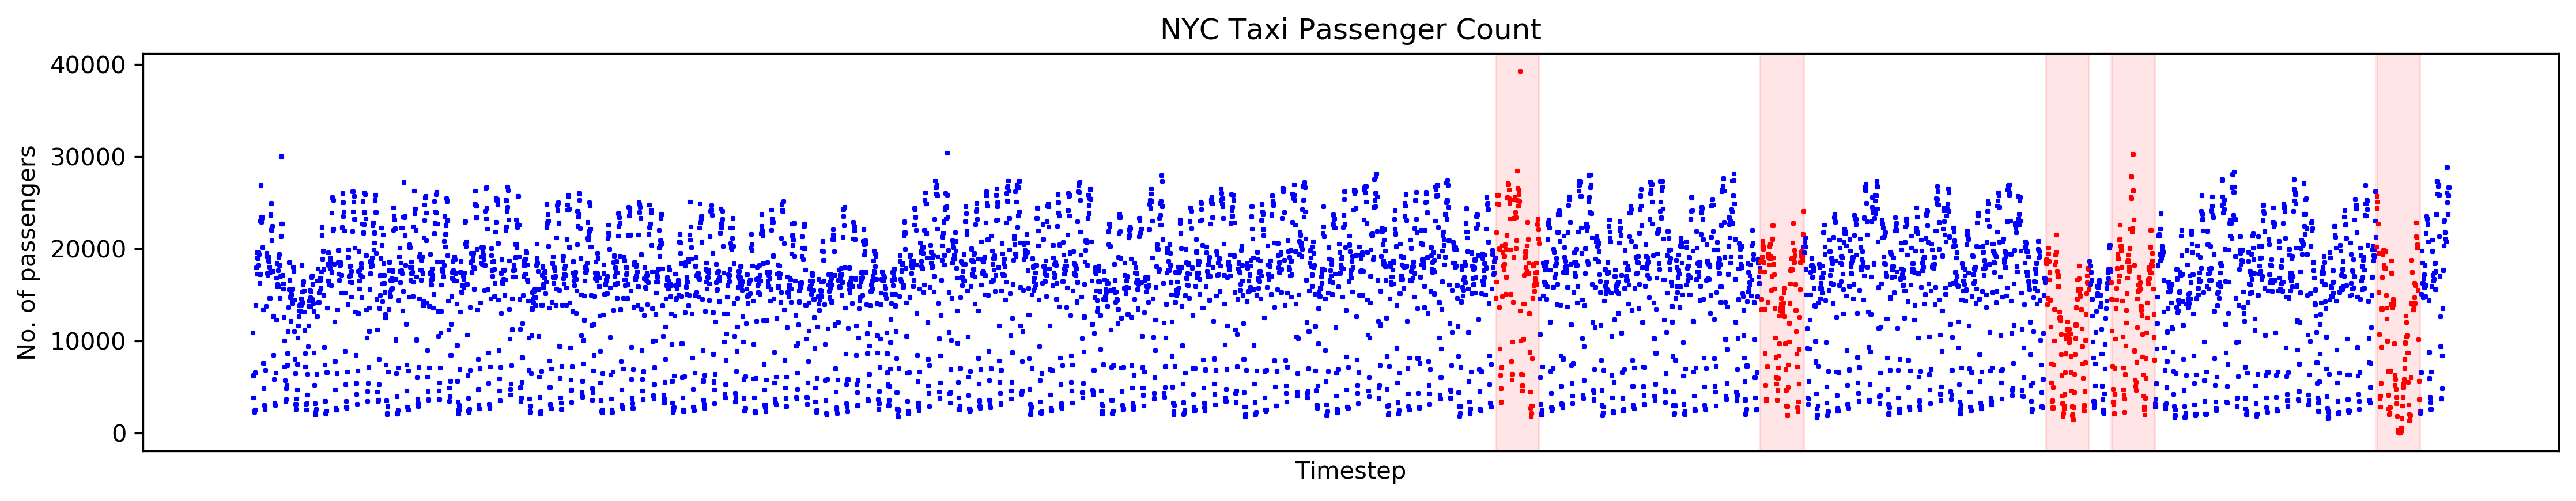

In [13]:
plot_time_series_nab_nyc_taxi(nyc_df.iloc[::2])

### Analysis/Interpretation

Positives:
* _Real world, noisy dataset_ - representative of the kind of graph that could result from the skyscanner data
* _Periodic data_ - though the cycle of the periods is smaller, there is a periodic pattern, similar to redirects

Neutral:
* _Anomalies are more subtle_ - can be a positive in that it is more realistic, but a negative in that detection can be rendered more difficult

Negatives:
* 10000 datapoints, still not a lot for deep learning
* __Univariate__ - we canot leverage cross-correlations between time series to detect anomalies, and is not representative of the skyscanner redirects summaries that the model will be run on


---
## Yahoo - A1 Benchmark

Real production data - 67 time series.

In [14]:
from data.yahoo.a1_benchmark import yahoo_a1_benchmark
yahoo_df = yahoo_a1_benchmark(clean_series=False)

In [15]:
yahoo_df.describe()

value_1        value_2      value_3       value_4       value_5  \
count  1461.000000    1461.000000  1461.000000   1461.000000   1461.000000   
mean      0.077464   10854.138261     2.997990    101.464066   2800.550992   
std       0.063745    7827.637944     1.132466    469.302901   2379.789597   
min       0.000000       0.000000     1.861944      0.000000      0.000000   
25%       0.034848    8836.000000     2.445000     41.000000   2057.000000   
50%       0.068025   10964.000000     2.802778     62.000000   2521.000000   
75%       0.104759   12675.000000     3.417500     85.000000   3334.000000   
max       0.787127  170029.000000    18.853056  12673.000000  83955.000000   

           value_6      value_7      value_8      value_9     value_10  ...  \
count  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000  ...   
mean    110.280630   275.499658   109.553730     0.030185     9.130364  ...   
std      36.711845   543.511115   430.404078     0.032911     1.293956  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%      85.000000     7.000000    24.000000     0.015000     8.880720  ...   
50%     113.000000    13.000000    46.000000     0.031389     9.180965  ...   
75%     135.000000    32.000000    81.000000     0.040000     9.499708  ...   
max     421.000000  2076.000000  5737.000000     1.075278    14.460025  ...   

          value_58     value_59     value_60     value_61     value_62  \
count  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000   
mean     22.891170     0.634013     1.006639   116.288843     0.128253   
std     104.031764     0.263540     0.405127   122.325935     0.269538   
min       0.000000     0.000000     0.610556     0.000000     0.000000   
25%       0.000000     0.591673     0.840556    18.000000     0.000000   
50%       3.000000     0.691789     0.951111    66.000000     0.068950   
75%      11.000000     0.782252     1.084722   192.000000     0.186694   
max     782.000000     1.000000    10.452778   882.000000     4.748427   

          value_63     value_64      value_65     value_66      value_67  
count  1461.000000  1461.000000   1461.000000  1461.000000   1461.000000  
mean     13.820980    12.253251   1693.185489    36.546201    184.479808  
std       2.607749     6.925944   1789.509573   191.648884    966.683797  
min       0.000000     0.000000      0.000000     0.000000      0.000000  
25%      12.509282     8.000000    622.000000     0.000000     25.000000  
50%      13.947131    11.000000   1226.000000     3.000000     72.000000  
75%      15.305098    16.000000   2081.000000     8.000000    106.000000  
max      23.526565    47.000000  23314.000000  2306.000000  12486.000000  

[8 rows x 67 columns]

In [16]:
def plot_time_series_yahoo_a1(dat):
    plt.ion()
    fig, axes = plt.subplots(67, 1, figsize=(15, 5*67), dpi=160)

    def color_map(value):
        if value is True:
            return (1,0,0)
        else:
            return (0,0,1)

    for num in range(1, 68):
        if f"value_{num}" not in dat.columns:
            continue
        
        ax = axes[num-1]
        ax.title.set_text(f"Series {num}")
        ax.scatter(dat.index, dat[f"value_{num}"], c=dat[f"anomaly_{num}"].apply(color_map), s=1, marker=",")
        ax.fill_between(dat.index, 0, 1, where=dat[f"anomaly_{num}"], color="red", alpha=0.2, transform=ax.get_xaxis_transform())
        ax.set_xticks([])
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Value")

    fig.tight_layout()
    plt.draw()
    plt.savefig(f"{OUTPUT_DIRECTORY}/yahoo_a1.png")


In [17]:
plot_time_series_yahoo_a1(yahoo_df)

### Analysis/Interpretation

Wow! Real production data from Yahoo seems to be very representative of the kinds of graphs seen in Skyscanner.

Positives:
* Very similar to redirects, real world datasets
* Anomalies are well labelled - tight to the anomaly and not encompassing many normal points
* Examples of many categories of anomalies
    * point anomalies / outliers - series 1,4,5,8,14,16,18,27,29,33,34,54-57
    * group anomalies - series 17,19,22,25,26,28,40,46,58,61
    * LOCAL/contextual anomalies - series 28,37,48
* Various examples of patterns: periodic, stationary, heteroskedastic, noisy, flatline

Negatives:
* 1461 datapoints is low for deep learning models

---



## NAB Tweets - points vs windows

The anomaly "windows" provided by NAB are very wide and do not accurately depcit anomalies in their pure form, which may be confusing for classifiers.

Below are plotted the NAB tweets series with only individual anomalous points identified.


In [18]:
point_tweet_df = nab_multivariate_tweet_volume(labels="points")

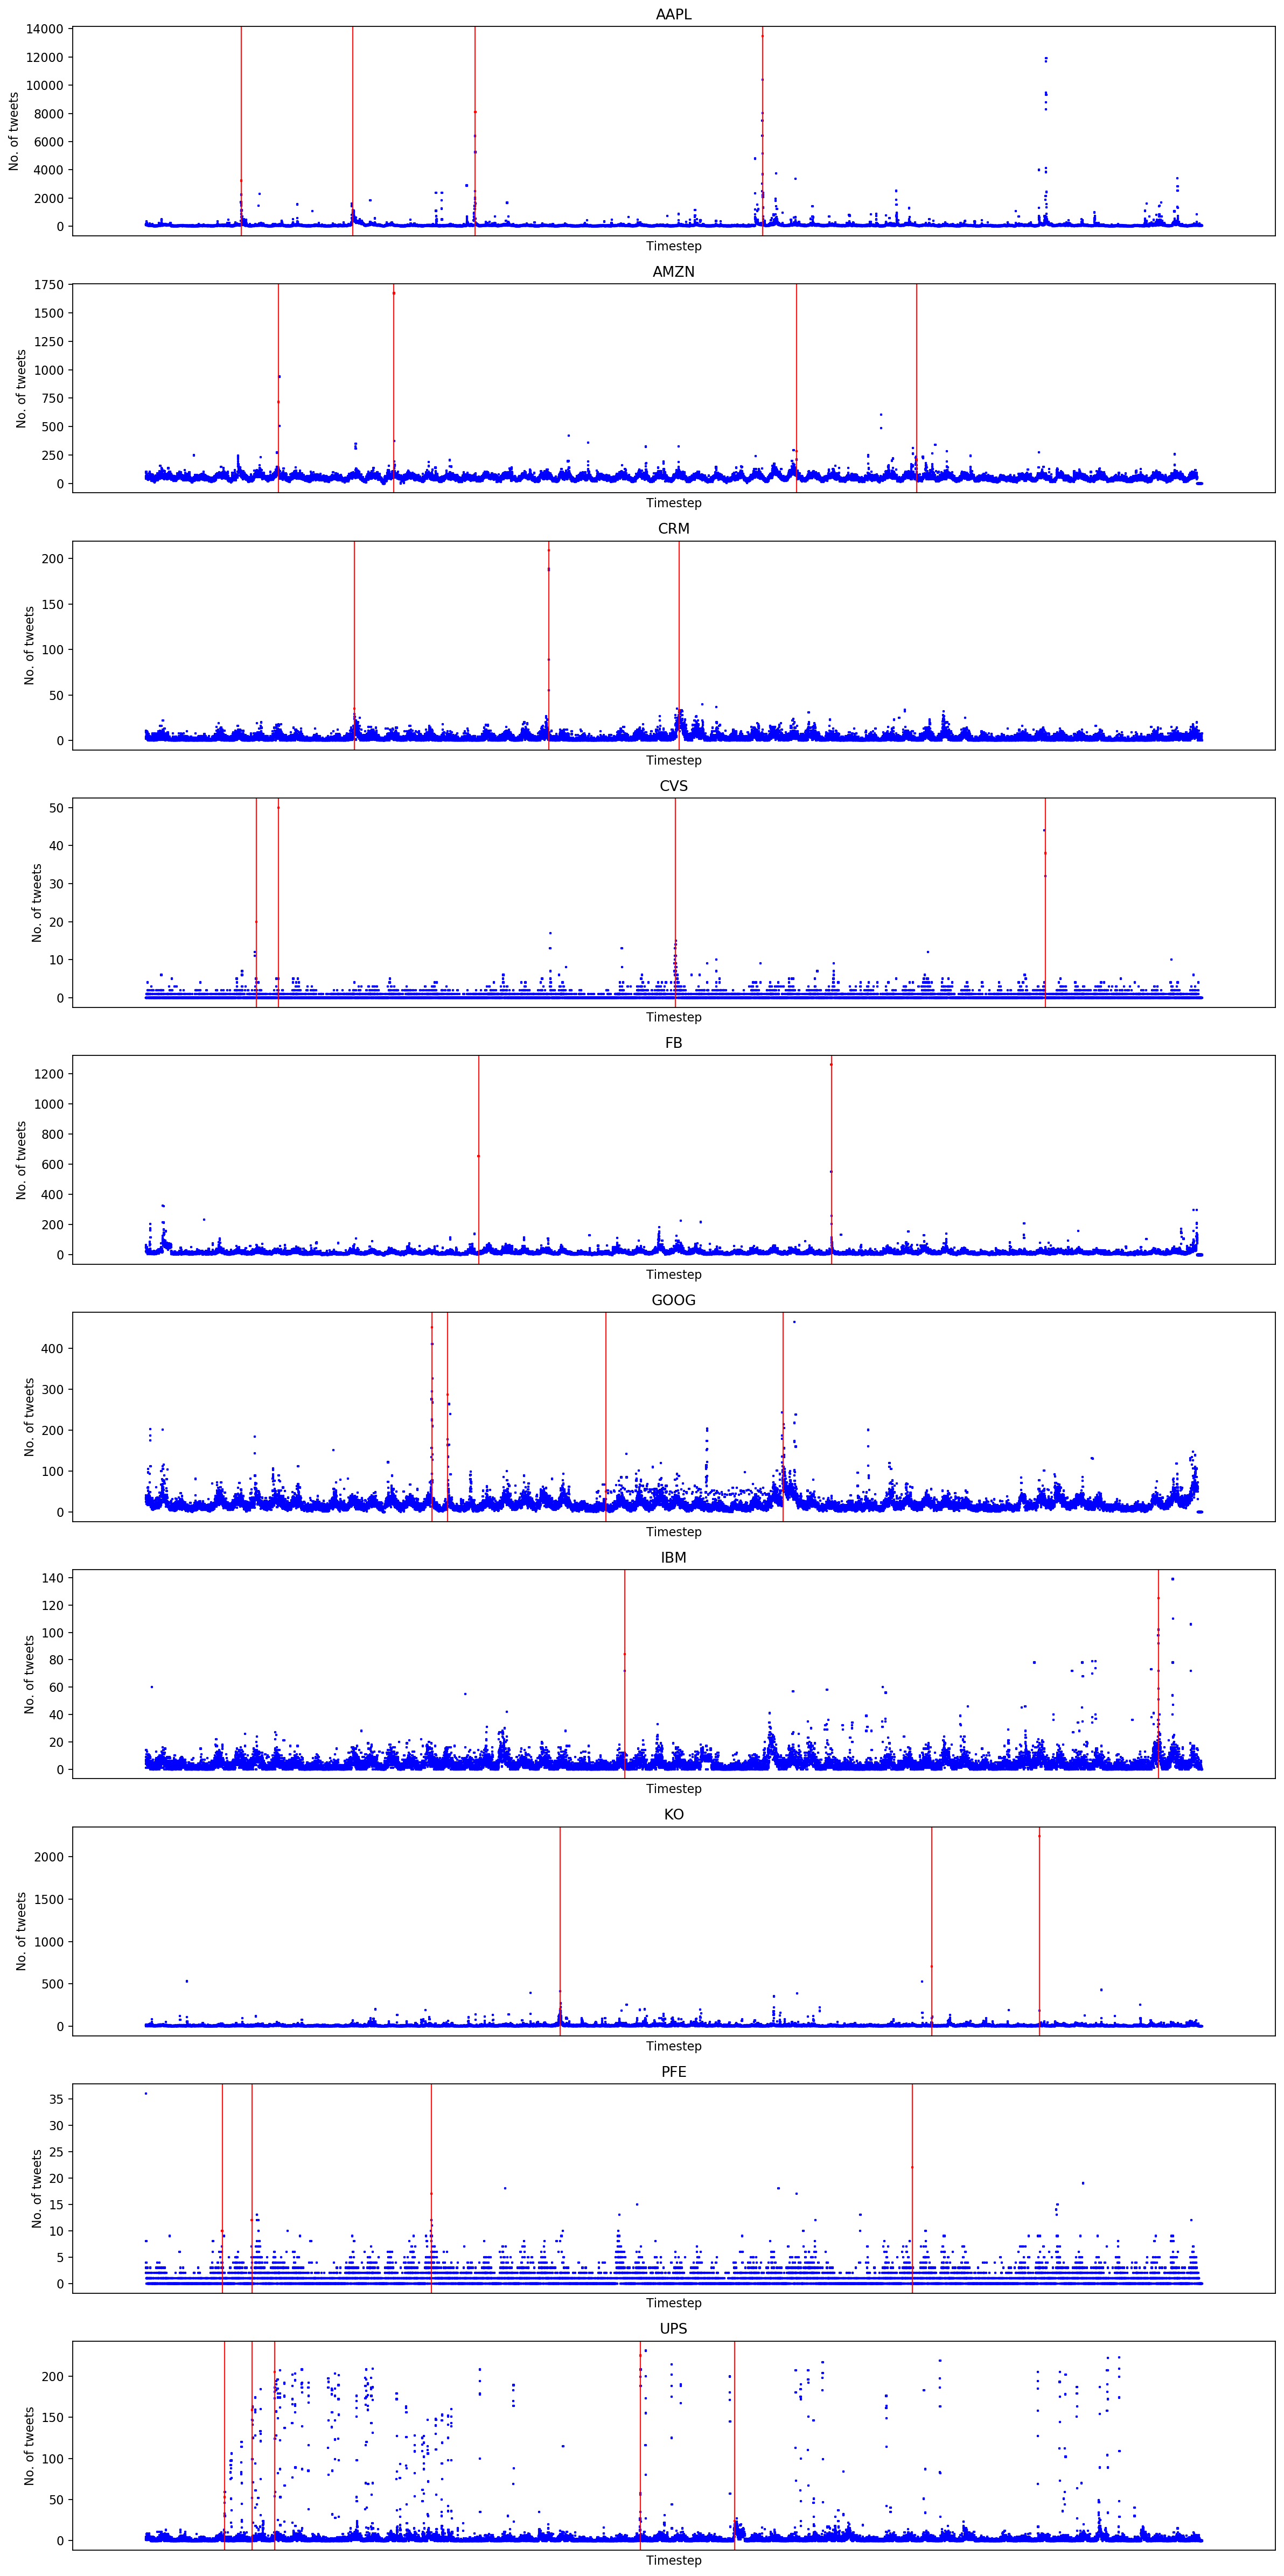

In [19]:
plot_time_series_nab_tweets(point_tweet_df, anomaly_alpha=0.9, extra_label="_points")